# Hearbet Sound Anomaly Detector - EDA

Dataset provided originally by Peterjbentleky Challenge (https://istethoscope.peterjbentley.com/heartchallenge/index.html)

## Getting data

In [62]:
import pandas as pd
from pathlib import Path

In [63]:
AUDIO_DIR = Path('../unzipped_data/')

In [64]:
set_a = pd.read_csv(AUDIO_DIR.joinpath('set_a.csv'))
set_b = pd.read_csv(AUDIO_DIR.joinpath('set_b.csv'))

print('set_a', set_a.shape)
print('set_b', set_b.shape)

set_a (176, 4)
set_b (656, 4)


In [65]:
set_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


`nan` values corresponding to unexisting files

In [66]:
set_a.isna().sum()

dataset       0
fname         0
label        52
sublabel    176
dtype: int64

In [67]:
set_a[set_a.label.isna()].head()

,dataset,fname,label,sublabel
124,a,set_a/__201012172010.wav,NaN,NaN
125,a,set_a/__201101051105.wav,NaN,NaN
126,a,set_a/__201101061552.wav,NaN,NaN
127,a,set_a/__201101091156.wav,NaN,NaN
128,a,set_a/__201101110659.wav,NaN,NaN


In [68]:
try:
    with open(AUDIO_DIR.joinpath('set_a/__201012172010.wav')) as f:
        print(f.read())
except Exception as e:
    print(e)

[Errno 2] No such file or directory: '../unzipped_data/set_a/__201012172010.wav'


## File categorization and Dataframe creation

These are inconsistences with the file names in `set_a` and may probably be present in `set_b` dataset. Therefore, these datasets are unstrustworthy. The best approach here is to iterate accross the directories and create a new dataframe with the true file names.wah

In [69]:
set(set_a.label) | set(set_b.label)

{'artifact', 'extrahls', 'extrastole', 'murmur', nan, 'normal'}

In [70]:
def list_files():
    for file in AUDIO_DIR.glob('**/*.wav'):
        yield file.as_posix()

def create_dataset():     
    data_files = []
    for filename in list_files():
        if filename.find('artifact')>-1:
            data_files.append((filename, 'artifact'))
        if filename.find('extrahls')>-1:
            data_files.append((filename, 'extrahls'))
        if filename.find('extrastole')>-1:
            data_files.append((filename, 'extrastole'))
        if filename.find('murmur')>-1:
            data_files.append((filename, 'murmur'))
        if filename.find('normal')>-1:
            data_files.append((filename, 'normal'))
    
    return pd.DataFrame(data_files, columns=('fname', 'label'))

In [71]:
%%time

audio_data = create_dataset()

CPU times: user 2.24 ms, sys: 10.2 ms, total: 12.5 ms
Wall time: 34.3 ms


In [72]:
audio_data.head()

,fname,label
0,../unzipped_data/set_a/artifact__201012172012.wav,artifact
1,../unzipped_data/set_a/artifact__201105040918.wav,artifact
2,../unzipped_data/set_a/artifact__201105041959.wav,artifact
3,../unzipped_data/set_a/artifact__201105051017.wav,artifact
4,../unzipped_data/set_a/artifact__201105060108.wav,artifact


Checking number of files:

In [73]:
# Pythonic way

audio_data.shape[0]

585

In [74]:
%%time

# With bash command

!ls -1 ../unzipped_data/**/*.wav | grep -v unlabelled | wc -l

585
CPU times: user 87.8 ms, sys: 31.3 ms, total: 119 ms
Wall time: 3.45 s


Removing unused variables to free memory resources

In [75]:
del set_a, set_b

## Classes distribution

In [76]:
import seaborn as sns

sns.set()

In [77]:
sns.countplot(x=audio_data.label)

<Axes: title={'center': 'Spectrogram'}, xlabel='label', ylabel='count'>

## Reproducing audio files

In [78]:
from IPython.display import Audio, display
import torchaudio
import librosa

I will try to reproduce a random recording for each group

In [79]:
recording_by_group = audio_data.groupby('label').sample().reset_index()
recording_by_group

,index,fname,label
0,6,../unzipped_data/set_a/artifact__201105190800.wav,artifact
1,43,../unzipped_data/set_a/extrahls__201101160804.wav,extrahls
2,164,../unzipped_data/set_b/extrastole__265_1309367...,extrastole
3,203,../unzipped_data/set_b/murmur__116_13062586899...,murmur
4,399,../unzipped_data/set_b/normal__125_13063324566...,normal


In [80]:
def load_audio_from_groupby():
    for item in recording_by_group.itertuples():
        y, sr = torchaudio.load(item.fname)
        yield (item.label.title(), item.fname), (y, sr)

In [81]:
for (label, fname), (_, sr) in load_audio_from_groupby():
    print('Label:', label, '- Path:', fname)
    display(Audio(fname, rate=sr))

Label: Artifact - Path: ../unzipped_data/set_a/artifact__201105190800.wav


Label: Extrahls - Path: ../unzipped_data/set_a/extrahls__201101160804.wav


Label: Extrastole - Path: ../unzipped_data/set_b/extrastole__265_1309367698923_C.wav


Label: Murmur - Path: ../unzipped_data/set_b/murmur__116_1306258689913_C.wav


Label: Normal - Path: ../unzipped_data/set_b/normal__125_1306332456645_B.wav


## Reading audio files with Librosa

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torch

### Plotting spectograms

In [184]:
def plot_waveform(waveform, sr, ax, title='Waveform'):
    waveform = waveform.numpy()

    _, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title, fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

def plot_spectrogram(transform_fn, waveform, ax=None):
    spect_db = transform_fn(waveform)
    if ax==None:
        _, ax = plt.subplots(1,1)
    ax.imshow(librosa.power_to_db(spect_db[0]), interpolation='nearest', origin='lower', aspect='auto')
    ax.set_title('Spectrogram', fontsize=9)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=8)

Showing a spectrogram example:

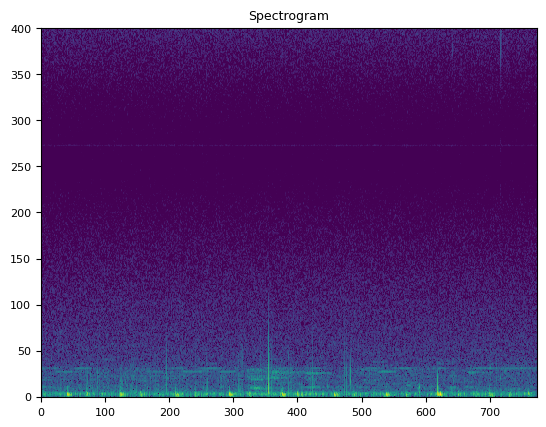

In [188]:
transform = torchaudio.transforms.Spectrogram(n_fft=800)

waveform, sr = torchaudio.load(recording_by_group.query('label=="extrahls"').fname.values[0])
plot_spectrogram(transform, waveform)
plt.show()

Plotting waveforms and spectrograms for each category:

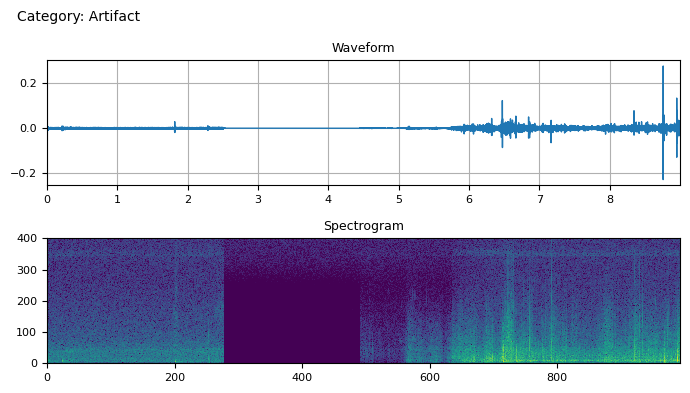

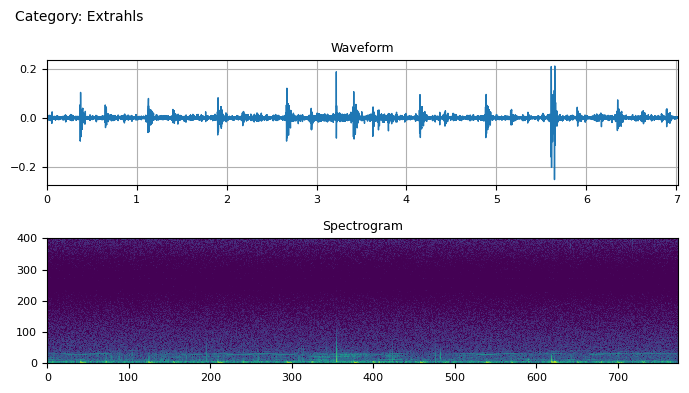

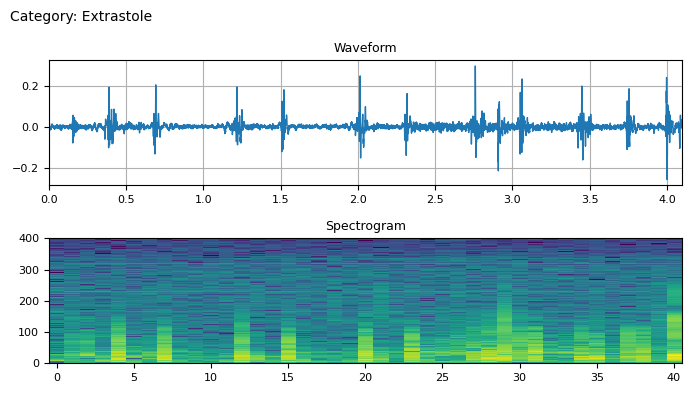

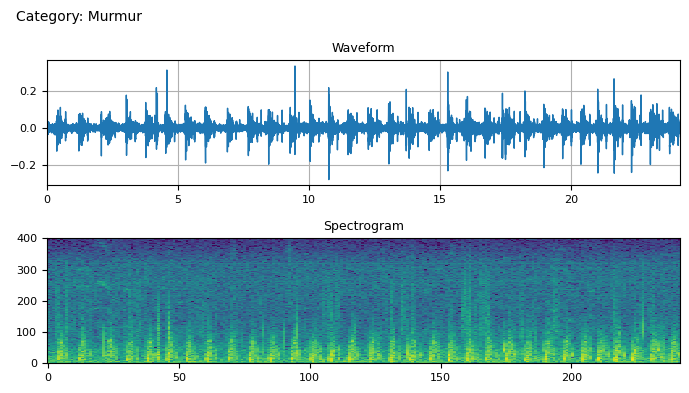

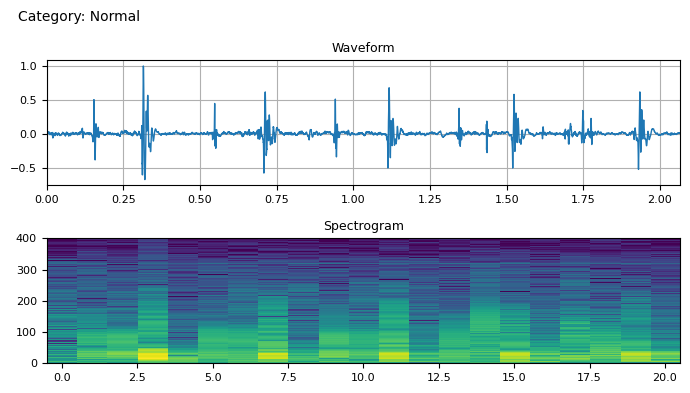

CPU times: user 19.3 s, sys: 969 ms, total: 20.3 s
Wall time: 18.9 s


In [195]:
%%time

transform = torchaudio.transforms.Spectrogram(n_fft=800)
sns.reset_orig()
for ((label, _), (y, sr)) in load_audio_from_groupby():
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 4))
    plt.subplots_adjust(hspace=.3)
    plot_waveform(waveform=y, sr=sr, ax=ax1)
    
    plot_spectrogram(transform, y, ax=ax2)
    plt.suptitle(f'Category: {label}', x=0.12, y=0.97, fontsize=10)
    fig.tight_layout()
    
    plt.show()

## Reshaping spectrograms

In the next cell, I will read all of the recordings in order to extract the dimensions of their spectrograms:

In [26]:
%%time

def load_spectrogram():
    for fname in audio_data.fname:
        y, sr = librosa.load(fname)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram)
        yield spectrogram

shape_spectrograms = []

for spectrogram in load_spectrogram():
    shape_spectrograms.append(spectrogram.shape)

shape_spectrograms = np.array(shape_spectrograms)

CPU times: user 2min 40s, sys: 2min 5s, total: 4min 46s
Wall time: 39.1 s


In [27]:
np.unique(shape_spectrograms[:, 0])

array([128])

All the spectrograms images have the same height measurement. Let's see their width:

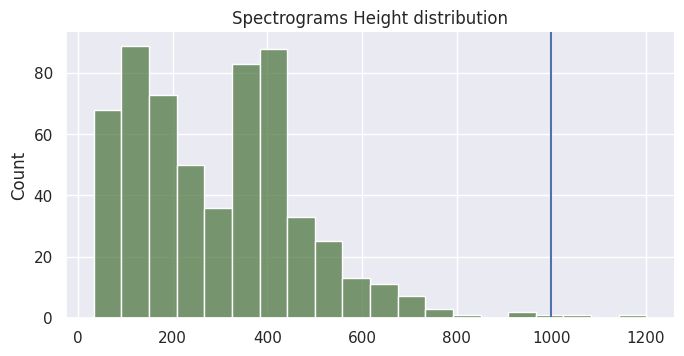

In [28]:
fig = sns.displot(shape_spectrograms[:, 1], height=3.5, aspect=2, color='#4F7942')

plt.axvline(1000)

fig.set(title='Spectrograms Height distribution')

`Shape[1]` or number of columns (in numpy arrays) equal to 1000 could be a good threshold; the width of the spectrograms exceeding this value will be trimmed and the remaining portion will be padded with zeros. By doing this, I will ensure that the shape of the spectrogram images will be uniform, and the neural network will not encounter any issue with the input shape.  

This threshold value will be configured as global parametrer in the application.

In [29]:
FIXED_LENGTH: int = 1000

def load_and_process():
    spectrograms_list = []
    for spectrogram in load_spectrogram():
        current_width: int = spectrogram.shape[1]
        if current_width > FIXED_LENGTH:
            spectrogram = spectrogram[:, :FIXED_LENGTH]
        else:
            spectrogram = np.pad(spectrogram, ((0, 0), (0, FIXED_LENGTH - current_width)))
            # Use np.concatenate() as alternative, but it is a bit more verbose compared to np.pad() which is designed for this purpose.
            #spect_db = np.concatenate((spect_db, np.zeros((spect_db.shape[0], LENGTH_DURATION - current_width))), axis=1)
        spectrograms_list.append(spectrogram)
    return spectrograms_list

In [30]:
%%time

audio_data['spectrograms'] = load_and_process()

CPU times: user 2min 8s, sys: 1min 35s, total: 3min 44s
Wall time: 29.7 s


In [76]:
audio_data.head()

,fname,label,spectrograms
0,../unzipped_data/set_a/artifact__201012172012.wav,artifact,"[[-33.711327, -36.412537, -42.775513, -42.2436..."
1,../unzipped_data/set_a/artifact__201105040918.wav,artifact,"[[-33.711327, -36.412537, -42.775513, -42.2436..."
2,../unzipped_data/set_a/artifact__201105041959.wav,artifact,"[[-33.711327, -36.412537, -42.775513, -42.2436..."
3,../unzipped_data/set_a/artifact__201105051017.wav,artifact,"[[-33.711327, -36.412537, -42.775513, -42.2436..."
4,../unzipped_data/set_a/artifact__201105060108.wav,artifact,"[[-33.711327, -36.412537, -42.775513, -42.2436..."


Now this dataframe with preprocessed data could be used as input for the neural network.